In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tables as tb

import panda2.panda2 as panda2
import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan

import os, time, sys
import importlib
import yaml


def get_pix_tdac(fraw, npix=1): 
    with tb.open_file(fraw) as f:
        comp1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp1_before')))
        comp0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp0_before')))
        tdac1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac1_before')))
        tdac0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac0_before')))
        arg = np.argwhere(comp1==1)
        if len(arg)!=npix:
            print('no comp1', arg, arg)
        else:
            return arg[0,0], arg[0,1], tdac1[arg[0,0], arg[0,1]]
        arg = np.argwhere(comp0==1)
        if len(arg)!=npix:
            print('no comp0', arg, arg)
        else:
            return arg[0,0], arg[0,1], tdac0[arg[0,0], arg[0,1]]
        return None

def get_conf(fraw, conf_name='IPDAC'):
    with tb.open_file(fraw) as f:
        conf = yaml.unsafe_load(f.root.meta_data.get_attr('firmware_before'))
        if conf_name in ['VDACBL']:
            return int(conf['CONF'][conf_name], 2)
        else:
            return int(conf['CONF'][conf_name][::-1], 2)

def plot_data(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('IPDAC', 'i'), ('tdac','i')])
    for i, fraw in enumerate(list_fraw):
        print(fraw)
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        print(fhit)
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row, tdac= get_pix_tdac(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
        #print(dat1)
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
            try:
                fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
                x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
                plt.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i%10))
            except:
                print(os.path.basename(fraw), nhit1)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            plt.plot(param['inj'], nhit1, 'C{}.'.format(i%10), label=label)
        
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')


    ## show x-axis and y-axis and legend
    plt.xlim(0,0.2)
    plt.xlabel('Injection[V]')
    plt.ylabel('#')
    plt.legend()
    return ret



In [ ]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
ret0 = np.load(os.path.join(os.path.join(datdir, 'results'), 'th_tdac0.npy'))
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac7'
ret7 = np.load(os.path.join(os.path.join(datdir, 'results'), 'th_tdac7.npy'))

th_3d=np.empty([29,62,2])

for r in ret0:
    th_3d[r['col'],r['row'],0] = r['th']
for r in ret7:
    th_3d[r['col'],r['row'],1] = r['th']   

In [15]:
#Loading data Hui
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall'
subdir = os.path.join(datdir,'results')
fname = os.path.join(subdir, 'res.npy')
ret = np.load(fname)  ### change variable name

sortret = ret[np.argsort(ret[['col','row','tdac']])]
uni, idx, cnt = np.unique(sortret[['col', 'row']], return_index=True, return_counts=True)
ret = sortret[['col','row','tdac','th','fname']].reshape([len(uni),len(sortret)//len(uni)])
##  pix  tdac
#ret[0   ,:   ][['col','row','tdac']]
#ret[:,   7   ]
print(ret[:,   7   ])

[(13,  0, 7, 0.10713863, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240609_235945_injection_scan.h5')
 (13,  1, 7, 0.0881585 , b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240609_235950_injection_scan.h5')
 (13,  2, 7, 0.10315623, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240609_235956_injection_scan.h5')
 (13,  3, 7, 0.09963503, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_000001_injection_scan.h5')
 (13,  4, 7, 0.09223487, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_000006_injection_scan.h5')
 (13,  5, 7, 0.08873785, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_000011_injection_scan.h5')
 (13,  6, 7, 0.09127754, b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_000016_injection_scan.h5')
 (13,  7, 7, 0.09079947, b'/home/hzhang/workspace/tmp/p

In [16]:
#looking for target Hui
#arg = np.argmin(ret[:,7]['th'])
#target = ret[:,7][arg]['th']
#ret[:,7][arg][['col','row','th']], target

#ivan !
arg = np.argsort(ret[:,7]['th'])
ret[:,7][arg][['col','row','th']][2]
target = ret[:,7][arg]['th'][2]
print(target)


0.08147177


0 2 13 0 2
1 6 13 1 6
2 3 13 2 3
3 4 13 3 4
4 5 13 4 5
5 6 13 5 6
6 5 13 6 5
7 5 13 7 5
8 5 13 8 5
9 3 13 9 3
10 4 13 10 4
11 4 13 11 4
12 4 13 12 4
13 4 13 13 4
14 4 13 14 4
15 3 13 15 3
16 5 13 16 5
17 4 13 17 4
18 4 13 18 4
19 5 13 19 5
20 3 13 20 3
21 4 13 21 4
22 5 13 22 5
23 5 13 23 5
24 4 13 24 4
25 5 13 25 5
26 4 13 26 4
27 6 13 27 6
28 5 13 28 5
29 5 13 29 5
30 4 13 30 4
31 5 13 31 5
32 4 13 32 4
33 6 13 33 6
34 2 13 34 2
35 7 13 35 7
36 6 13 36 6
37 5 13 37 5
38 4 13 38 4
39 5 13 39 5
40 5 13 40 5
41 5 13 41 5
42 3 13 42 3
43 4 13 43 4
44 5 13 44 5
45 6 13 45 6
46 3 13 46 3
47 4 13 47 4
48 3 13 48 3
49 3 13 49 3
50 3 13 50 3
51 4 13 51 4
52 4 13 52 4
53 6 13 53 6
54 7 13 54 7
55 5 13 55 5
56 7 13 56 7
57 4 13 57 4
58 3 13 58 3
59 4 13 59 4
60 5 13 60 5
61 5 13 61 5
62 2 14 0 2
63 4 14 1 4
64 5 14 2 5
65 4 14 3 4
66 3 14 4 3
67 3 14 5 3
68 3 14 6 3
69 5 14 7 5
70 4 14 8 4
71 5 14 9 5
72 5 14 10 5
73 4 14 11 4
74 6 14 12 6
75 6 14 13 6
76 3 14 14 3
77 5 14 15 5
78 7 14 16 7
79 

array([(b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_012016_injection_scan.h5', 0.08199905, 2.75468083e-05, 13,  0, 50, 2),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_001557_injection_scan.h5', 0.08271889, 9.59038371e-05, 13,  1, 50, 6),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_010421_injection_scan.h5', 0.07891397, 4.93314583e-05, 13,  2, 50, 3),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_004820_injection_scan.h5', 0.08234433, 6.21198633e-05, 13,  3, 50, 4),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_003218_injection_scan.h5', 0.08056371, 9.04136250e-05, 13,  4, 50, 5),
       (b'/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacall/20240610_001618_injection_scan.h5', 0.08286354, 9.38097364e-05, 13,  5, 50, 6),
       (b'/home/hzhang/works

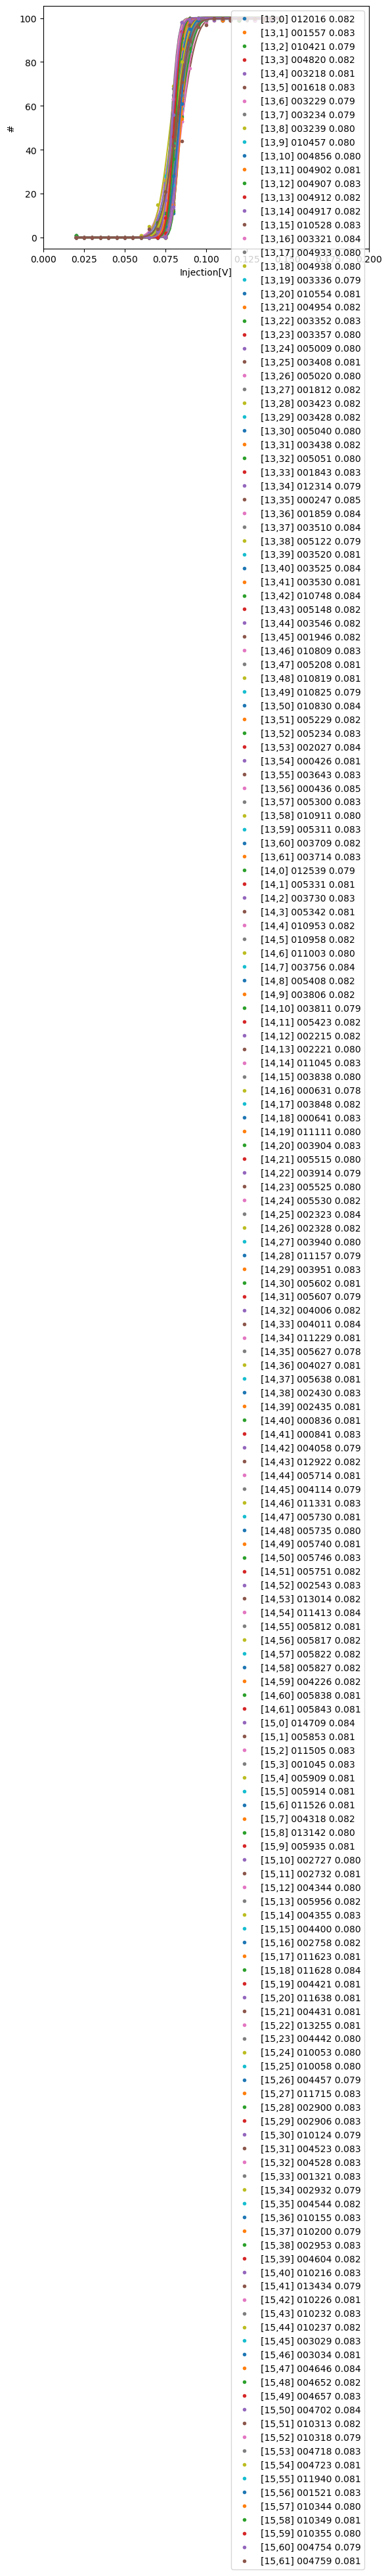

In [17]:
#finding optimum Hui
list_fraw = []
arg = np.argmin(np.abs(ret['th'] - target), axis=1)
tuned_tdac=np.ones([29,62], dtype='i')*7
for i, a in enumerate(arg):
    c, r, t = ret[i,a][['col','row','tdac']]
    print(i, a, c, r, t)
    decoded_fname = ret[i,a]['fname'].decode("ascii")
    list_fraw.append(decoded_fname)
    tuned_tdac[c, r] = t

fname = np.save(os.path.join(subdir,'tuned_tdac.npy'), tuned_tdac)
plot_data(list_fraw)

In [ ]:
#ivan !
arg = np.argsort(ret[:,7]['th'])
ret[:,7][arg][['col','row','th']][2]
target = ret[:,7][arg][['th']][2]

In [ ]:

arg = np.argmin(ret7['th'])
target = ret7[arg][['th']][0]
ret7[arg][['col','row','th']],target


In [ ]:
arg = np.argsort(ret['th'])[3]
ret[arg][['col','row','th']]

In [ ]:
np.min(ret['th'])

In [ ]:
tuned_tdac = np.argmin(np.abs( - target), axis=2)

In [ ]:
dut.set_tdac(tuned_tdac)

In [ ]:
plt.imshow(np.transpose(th_3d[:,:,1]))
plt.colorbar()

In [ ]:
arg = np.argmax(ret7['th'])
ret[arg][['col','row','th']]

In [ ]:
dut.mask_rx(False)
time.sleep(1)
dut.mask_rx(True)
raw = dut.get_data_now()

import panda.analysis.interpreter as inpterpreter
ts, hit = inpterpreter(raw)
len(raw), len(ts), len(hit), hit